In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.datasets import ImageFolder 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.auto import tqdm

# Advanced Augmentation Library
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- Global Configuration ---
NUM_CLASSES = 3 
CLASS_NAMES = ['Normal', 'Benign', 'Malignant']
IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 50 # Le code original utilisait 50, ce qui a bien fonctionné
NUM_WORKERS = 0 # Prevents multiprocessing cleanup errors on some systems/Kaggle

# --- Device Configuration (Standard for Kaggle/CUDA) ---
# --- FIX: Moved DEVICE definition out of the comment line ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

try:
    if DEVICE.type == 'cuda':
        torch.rand(1).to(DEVICE)
        print("✅ CUDA/Standard GPU successfully initialized.")
except Exception as e:
    print(f"❌ Failed to initialize device test: {e}")

✅ Using device: cuda
✅ CUDA/Standard GPU successfully initialized.


In [4]:
def build_convnext_tiny_base(num_classes):
    # Load pre-trained ConvNeXt Tiny
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    
    # Get the number of features for the classifier head
    feature_dim = model.classifier[2].in_features
    
    # Replace the classification head
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),           
        nn.Linear(feature_dim, num_classes)
    )
    
    return model

# Function to count parameters
def count_all_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    untrainable_params = total_params - trainable_params
    return total_params, trainable_params, untrainable_params

# Initialize and Count
model = build_convnext_tiny_base(NUM_CLASSES).to(DEVICE)
total, trainable, untrainable = count_all_parameters(model)

print(f"✅ ConvNeXt-Tiny Base Model initialized. All layers are trainable by default.")
print("--- Model Parameter Count ---\n")
print(f"⭐ Total Parameters:        {total:,}")
print(f"⭐ Trainable Parameters:    {trainable:,}")
print(f"⭐ Untrainable Parameters:  {untrainable:,}")

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 186MB/s]  


✅ ConvNeXt-Tiny Base Model initialized. All layers are trainable by default.
--- Model Parameter Count ---

⭐ Total Parameters:        27,820,899
⭐ Trainable Parameters:    27,820,899
⭐ Untrainable Parameters:  0


In [6]:
# --- A. Loss Function (Standard CrossEntropyLoss) ---
# REVERTING to standard loss. The custom weights were incorrect and stopping the model from training.
CRITERION = nn.CrossEntropyLoss().to(DEVICE)
print("⭐ Using Standard CrossEntropyLoss for training.")

# --- B. Standard Augmentation Pipelines ---
# --- FIX: Moved definitions out of the comment line ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2), 
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.6),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])
# Test transform is the same as validation transform
test_transform = val_transform

# --- C. Data Loading and Splitting ---

# Helper class to apply transforms to a subset
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        path, label = self.subset.dataset.samples[self.subset.indices[index]]
        img = np.array(Image.open(path).convert("RGB"))

        if self.transform is not None:
            augmented = self.transform(image=img)
            img = augmented['image']
        
        return img, label

    def __len__(self):
        return len(self.subset)

# 1. Load the entire dataset from your single path
DATA_PATH = '/kaggle/input/cancerclassification/Classification/Image' 
print(f"Attempting to load data from: {DATA_PATH}\n")

try:
    full_dataset = ImageFolder(DATA_PATH)
    
    # 2. Define the split sizes (80% Train, 10% Validation, 10% Test)
    TRAIN_RATIO = 0.80
    VAL_RATIO = 0.10
    
    total_size = len(full_dataset)
    train_size = int(TRAIN_RATIO * total_size)
    val_size = int(VAL_RATIO * total_size)
    test_size = total_size - train_size - val_size # Ensure all samples are used
    
    # 3. Perform a 3-way random split
    train_subset, val_subset, test_subset = random_split(
        full_dataset, 
        [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # 4. Apply the correct Albumentations transforms to the subsets
    train_dataset = SubsetWithTransform(train_subset, transform=train_transform)
    val_dataset = SubsetWithTransform(val_subset, transform=val_transform)
    test_dataset = SubsetWithTransform(test_subset, transform=test_transform)
    
    print(f"✅ Data loaded successfully. Total: {total_size}")
    print(f"  -> Train: {len(train_dataset)} ({TRAIN_RATIO*100:.0f}%)")
    print(f"  -> Val:   {len(val_dataset)} ({VAL_RATIO*100:.0f}%)")
    print(f"  -> Test:  {len(test_dataset)} ({100 - (TRAIN_RATIO*100) - (VAL_RATIO*100):.0f}%)")


except Exception as e:
    raise RuntimeError(f"CRITICAL DATA ERROR: Failed to load data from {DATA_PATH}. Check your path and folder structure. Error: {e}")


# 5. Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\n✅ DataLoaders initialized with NUM_WORKERS={NUM_WORKERS}, BATCH_SIZE={BATCH_SIZE}.")

⭐ Using Standard CrossEntropyLoss for training.
Attempting to load data from: /kaggle/input/cancerclassification/Classification/Image

✅ Data loaded successfully. Total: 1665
  -> Train: 1332 (80%)
  -> Val:   166 (10%)
  -> Test:  167 (10%)

✅ DataLoaders initialized with NUM_WORKERS=0, BATCH_SIZE=64.


In [7]:
# --- SGD Optimizer (Replaced AdamW) ---
LEARNING_RATE = 1e-3 # SGD often uses a slightly higher initial LR
WEIGHT_DECAY = 1e-2 
MOMENTUM = 0.9

OPTIMIZER = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) 
print(f"⭐ SGD Optimizer initialized with LR={LEARNING_RATE}, Momentum={MOMENTUM}, Weight Decay={WEIGHT_DECAY}")


# --- Learning Rate Scheduler ---
SCHEDULER = lr_scheduler.CosineAnnealingLR(OPTIMIZER, T_max=NUM_EPOCHS) 
print("⭐ Cosine Annealing LR Scheduler initialized.")


# Training Function
def train_one_epoch(model, dataloader, criterion, optimizer, device, scheduler):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += loss.item() * images.size(0)
    
    scheduler.step() # Decay LR after the epoch
    return running_loss / len(dataloader.dataset)

# Evaluation Function (used for both Validation and Test)
def evaluate(model, dataloader, criterion, device, desc="Validation"):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=desc):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Main Training Loop
train_losses = []
val_losses = []
val_accuracies = []
# These will store the TEST results at the end
final_labels, final_preds, final_probs = None, None, None 

print(f"\n--- Starting Training for {NUM_EPOCHS} Epochs ---")
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, CRITERION, OPTIMIZER, DEVICE, SCHEDULER)
    
    # Evaluate on validation set during training
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, CRITERION, DEVICE, desc="Validation")

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

print("✅ Training complete.")

# --- Final Evaluation on Test Set ---\n# (Uses the test_loader created in Cell 3)
print(f"\n--- Running Final Evaluation on Test Set ---")
test_loss, test_acc, final_labels, final_preds, final_probs = evaluate(
    model, 
    test_loader, 
    CRITERION, 
    DEVICE, 
    desc="Testing"
)
print(f"✅ Test Evaluation Complete | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

⭐ SGD Optimizer initialized with LR=0.001, Momentum=0.9, Weight Decay=0.01
⭐ Cosine Annealing LR Scheduler initialized.

--- Starting Training for 50 Epochs ---


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.0813 | Val Loss: 1.0505 | Val Acc: 0.4940


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0451 | Val Loss: 0.9910 | Val Acc: 0.5783


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9951 | Val Loss: 0.9038 | Val Acc: 0.5783


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9357 | Val Loss: 0.8222 | Val Acc: 0.6566


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.9109 | Val Loss: 0.7733 | Val Acc: 0.7169


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.8709 | Val Loss: 0.6627 | Val Acc: 0.7711


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.8160 | Val Loss: 0.6647 | Val Acc: 0.7530


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.8074 | Val Loss: 0.5915 | Val Acc: 0.7711


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.7739 | Val Loss: 0.5799 | Val Acc: 0.7590


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.7365 | Val Loss: 0.4926 | Val Acc: 0.8253


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.7013 | Val Loss: 0.4838 | Val Acc: 0.7771


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.6547 | Val Loss: 0.5561 | Val Acc: 0.7470


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.6460 | Val Loss: 0.4773 | Val Acc: 0.7831


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.6536 | Val Loss: 0.4940 | Val Acc: 0.8133


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.6436 | Val Loss: 0.3752 | Val Acc: 0.8614


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.6107 | Val Loss: 0.3720 | Val Acc: 0.8614


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.5829 | Val Loss: 0.3589 | Val Acc: 0.8554


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.5865 | Val Loss: 0.4447 | Val Acc: 0.7892


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.5738 | Val Loss: 0.3708 | Val Acc: 0.8434


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.5699 | Val Loss: 0.3885 | Val Acc: 0.8253


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.5430 | Val Loss: 0.3411 | Val Acc: 0.8373


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.5217 | Val Loss: 0.3325 | Val Acc: 0.8675


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.5202 | Val Loss: 0.3464 | Val Acc: 0.8494


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.5235 | Val Loss: 0.3721 | Val Acc: 0.8434


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.5076 | Val Loss: 0.3914 | Val Acc: 0.8434


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.5101 | Val Loss: 0.3966 | Val Acc: 0.8614


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.4912 | Val Loss: 0.3531 | Val Acc: 0.8675


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.4875 | Val Loss: 0.3519 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.4522 | Val Loss: 0.3311 | Val Acc: 0.8494


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.4763 | Val Loss: 0.3506 | Val Acc: 0.8614


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.4472 | Val Loss: 0.3205 | Val Acc: 0.8614


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.4738 | Val Loss: 0.3710 | Val Acc: 0.8494


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.4676 | Val Loss: 0.3204 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.4309 | Val Loss: 0.3395 | Val Acc: 0.8494


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.4426 | Val Loss: 0.3080 | Val Acc: 0.8675


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.4432 | Val Loss: 0.2920 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.4202 | Val Loss: 0.3067 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.4093 | Val Loss: 0.3001 | Val Acc: 0.8675


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.3891 | Val Loss: 0.3071 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.4062 | Val Loss: 0.3084 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.3912 | Val Loss: 0.3197 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.3868 | Val Loss: 0.3224 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.3980 | Val Loss: 0.3076 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.3923 | Val Loss: 0.3116 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.3847 | Val Loss: 0.3063 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.3891 | Val Loss: 0.3076 | Val Acc: 0.8675


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.3919 | Val Loss: 0.3112 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.3691 | Val Loss: 0.3101 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.3846 | Val Loss: 0.3104 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.3889 | Val Loss: 0.3104 | Val Acc: 0.8795
✅ Training complete.

--- Running Final Evaluation on Test Set ---


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Test Evaluation Complete | Test Loss: 0.3649 | Test Acc: 0.8683



## 1. Test Set Classification Report (Aiming for 85%+ Precision/Recall)
-----------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.91      0.84      0.87        80
      Benign       0.76      0.80      0.78        35
   Malignant       0.89      0.96      0.93        52

    accuracy                           0.87       167
   macro avg       0.85      0.87      0.86       167
weighted avg       0.87      0.87      0.87       167



<Figure size 800x600 with 0 Axes>

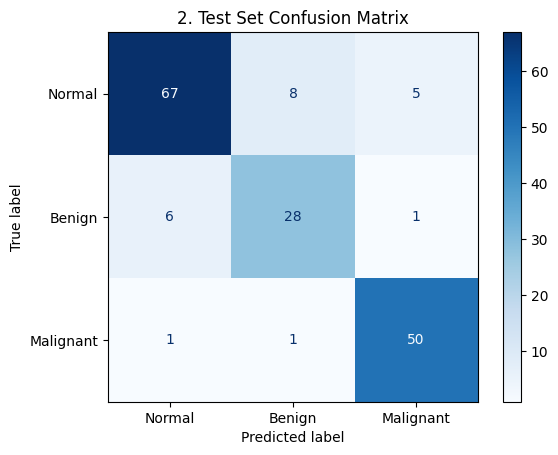

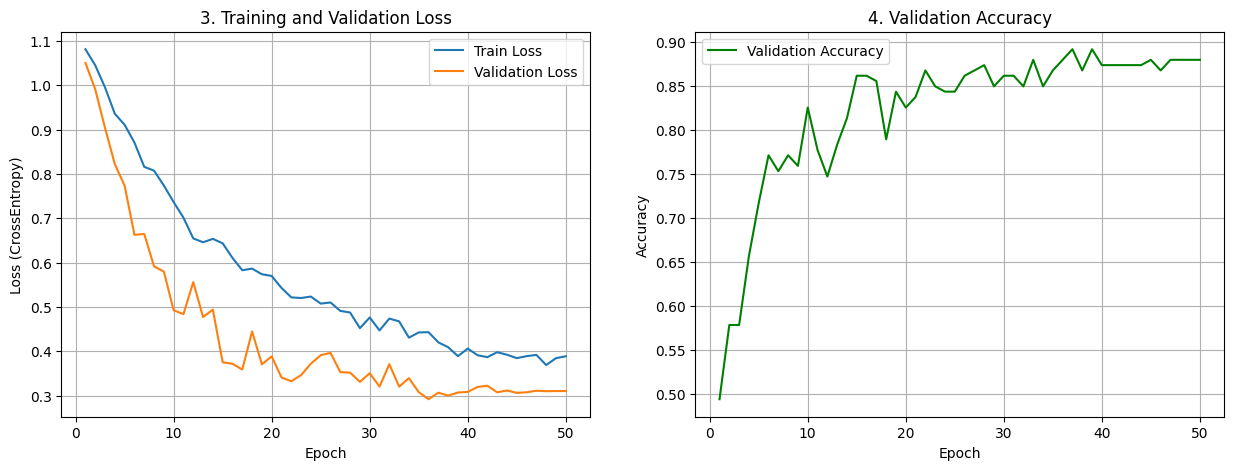

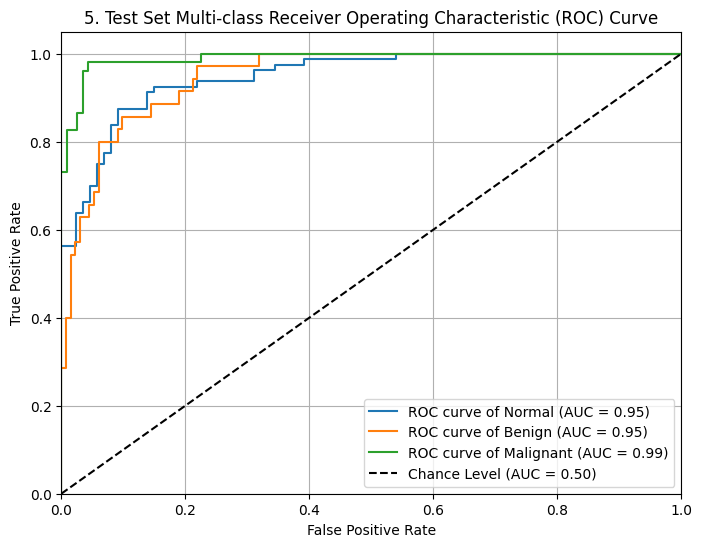

✅ All test set evaluation metrics and plots generated.


In [9]:
# --- A. Test Set Classification Report ---
if final_labels is not None:
    print("\n## 1. Test Set Classification Report (Aiming for 85%+ Precision/Recall)")
    print("-----------------------------------------------------------------")
    # Set zero_division=0 to handle cases where a class might not be predicted
    print(classification_report(final_labels, final_preds, target_names=CLASS_NAMES, zero_division=0))

    # --- B. Test Set Confusion Matrix Plot ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(final_labels, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues) 
    plt.title('2. Test Set Confusion Matrix')
    plt.show()

    # --- C. Validation Loss and Accuracy Plots (During Training) ---
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    ax[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    ax[0].set_title('3. Training and Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss (CrossEntropy)')
    ax[0].legend()
    ax[0].grid(True)

    # Accuracy Plot
    ax[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    ax[1].set_title('4. Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

    # --- D. Test Set ROC Curve Plot (One vs. Rest) ---
    plt.figure(figsize=(8, 6))
    y_true_one_hot = np.eye(NUM_CLASSES)[final_labels]

    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], final_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve of {CLASS_NAMES[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('5. Test Set Multi-class Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("✅ All test set evaluation metrics and plots generated.")
else:
    print("⚠️ Cannot generate plots: Training did not run or failed to produce test results.")